# 1. Import and loading data

In [37]:
# ! kaggle datasets download carlmcbrideellis/zzzs-lightweight-training-dataset-target -p data/ --unzip 


In [38]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
from tqdm.auto import tqdm

import xgboost as xgb
from xgboost import  XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics

import gc # garbage collector to free memory
# Set display options to show large numbers without exponential notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


%matplotlib inline

we will use shink data in this notebook for memory optimization 

In [39]:
# data = pd.read_parquet('../data/Zzzs_train.parquet').sample(frac=0.1,random_state=42)
data = pd.read_parquet('../data/Zzzs_train.parquet')
# print(data.shape)
data = data[data['series_id'].isin([
    '08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e',
    '10f8bc1f7b07', '18b61dd5aae8'])]
print(data.shape)

(2380680, 6)


In [42]:
data[data['awake']==0].tail(1).to_dict()

{'series_id': {2380188: '18b61dd5aae8'},
 'step': {2380188: 495048},
 'timestamp': {2380188: '2018-01-20T08:04:00-0500'},
 'anglez': {2380188: 34.02190017700195},
 'enmo': {2380188: 0.0},
 'awake': {2380188: 0}}

# 2. Data cleaning and data preparation

In [4]:

# convert timestamp to datatime dtype. There are Daylight saving time issues in dataset
data['timestamp'] = pd.to_datetime(data['timestamp']).apply(lambda t: t.tz_localize(None)) 
data.info()

/tmp/ipykernel_12556/3557258119.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['timestamp'] = pd.to_datetime(data['timestamp']).apply(lambda t: t.tz_localize(None))


<class 'pandas.core.frame.DataFrame'>
Index: 2380680 entries, 0 to 2380679
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  datetime64[ns]
 3   anglez     float32       
 4   enmo       float32       
 5   awake      int64         
dtypes: datetime64[ns](1), float32(2), int64(1), object(1), uint32(1)
memory usage: 99.9+ MB


### Lets optimize data dtype to not run out of memory even if it is not the task for midterm project it is always a good idea to improve peroformance on the large scale data, especcially if it's not hard to implement


In [5]:
from pandas.api.types import is_datetime64_ns_dtype

def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
            elif  str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
    df['series_id'] = df['series_id'].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [6]:
data=reduce_mem_usage(data)

Memory usage of dataframe is 99.90 MB
Memory usage after optimization is: 68.11 MB
Decreased by 31.82%


In [7]:
# optimized data info

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2380680 entries, 0 to 2380679
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  category      
 1   step       uint32        
 2   timestamp  datetime64[ns]
 3   anglez     float32       
 4   enmo       float32       
 5   awake      int8          
dtypes: category(1), datetime64[ns](1), float32(2), int8(1), uint32(1)
memory usage: 68.1 MB


# 3. EDA. Lets look at data closely


In [8]:
data.isna().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
awake        0
dtype: int64

In [9]:
# count the number of unique values in train_series
n_series = data.nunique()
print(f'Unique values in train_series are: \n{n_series}')

Unique values in train_series are: 
series_id          6
step          495540
timestamp    2379960
anglez       1005068
enmo           12404
awake              2
dtype: int64


target distribution

In [10]:
data['awake'].value_counts(normalize=True)

awake
1   0.662
0   0.338
Name: proportion, dtype: float64

# What is step column?
From the competition data description it is known that:

* Step - An integer timestep for each observation within a series.
* Each series is a continuous recording.
* Each data series represents this continuous (multi-day/event) recording for a unique experimental subject.

From the first 5 rows of the train_series dataframe it is seen that one step = 5 seconds. Let's check if all the records have a step = 5 sec.


In [11]:

# calcuate ho many steps were performed for every series
series_id=data.groupby('series_id').step.count()
series_id.reset_index().describe()


/tmp/ipykernel_12556/4121966310.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  series_id=data.groupby('series_id').step.count()


,step
count,6.000
mean,396780.000
std,79485.821
min,256860.000
25%,386595.000
50%,401670.000
75%,432945.000
max,495540.000


In [12]:
# we see that number of steps vary for the series. Lets then see what is the duration of observation for series. 
data['duration'] = data.groupby('series_id')['timestamp'].transform(lambda x: x.max() - x.min())

# Extract the number of days from the duration
data['duration_days'] = data['duration'].dt.days

# Drop duplicates to get unique 'series_id' values with their respective durations
result = data[['series_id', 'duration_days']].drop_duplicates()

# Print the result
print(result)

/tmp/ipykernel_11696/1831093274.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['duration'] = data.groupby('series_id')['timestamp'].transform(lambda x: x.max() - x.min())


            series_id  duration_days
0        08db4255286f             25
440280   0a96f4993bd7             14
697140   0cfc06c129cc             22
1081800  1087d7b0ff2e             23
1492740  10f8bc1f7b07             22
1885140  18b61dd5aae8             28
2380680  29c75c018220             26
2844900  3452b878e596             30


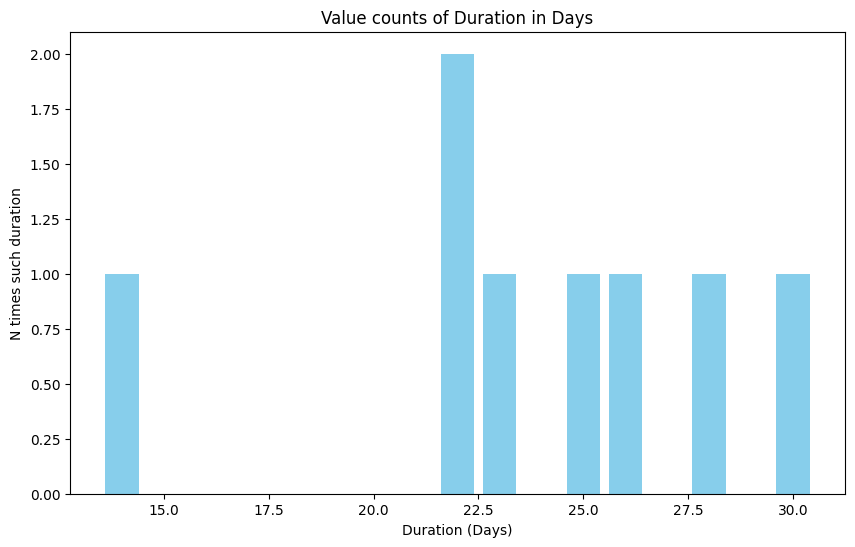

In [13]:
# lets visulize it
import matplotlib.pyplot as plt
value_counts = result['duration_days'].value_counts()

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(value_counts.index, value_counts.values, color='skyblue')


# Add labels and title
plt.xlabel('Duration (Days)')
plt.ylabel('N times such duration')
plt.title('Value counts of Duration in Days')

# Show the plot
plt.show()


# the main features
## enmo and anglez data analysis
Definitions.
Competition data description provides the following information:

enmo - as calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

anglez - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body.


In [14]:
#### Here we can see descriptive statistics of  enmo and anlez. It is noticable that enmo is biased and has outliers for max values. Lets take a look closely 

data[['enmo','anglez']].describe().round(4)


,enmo,anglez
count,3380400.000,3380400.000
mean,0.044,-11.277
std,0.106,36.868
min,0.000,-90.000
25%,0.000,-39.563
50%,0.014,-11.640
75%,0.044,12.781
max,5.897,89.694


/tmp/ipykernel_11696/553249965.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data.enmo)


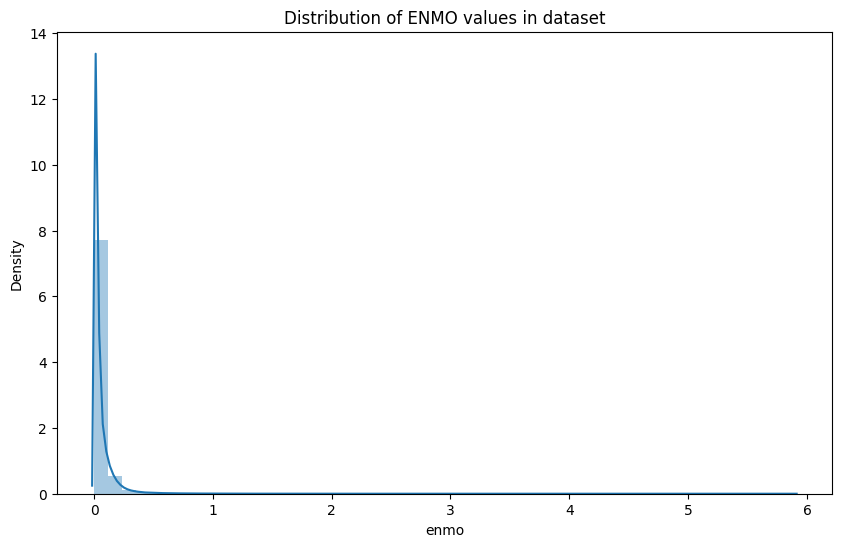

In [15]:
# plot the distribution of enmo-values
plt.figure(figsize=(10, 6))
ax = sns.distplot(data.enmo)
plt.title('Distribution of ENMO values in dataset')
plt.show()

on this  we see that most of the data lies in the range 0-1. For better permormance of the model we should deal with outliers. For that, lets replace these outliers with valies on 0.99 percentile (we will add it to feature engineering)


In [16]:
data[['enmo']].describe(percentiles=[.25, .5, .75, 0.95, 0.99]).round(4)


,enmo
count,3380400.000
mean,0.044
std,0.106
min,0.000
25%,0.000
50%,0.014
75%,0.044
95%,0.175
99%,0.435
max,5.897


In [17]:
q_99=data['enmo'].quantile(0.99)

mask=data['enmo']>q_99
data['enmo_updated'] = np.where(mask, q_99, data['enmo'])
data[['enmo_updated']].describe(percentiles=[.25, .5, .75, 0.95, 0.99]).round(4)
del data['enmo_updated']


ANGLEZ metric data analysis



In [18]:
data[['anglez']].describe(percentiles=[.25, .5, .75, 0.95, 0.99]).round(4)

,anglez
count,3380400.000
mean,-11.277
std,36.868
min,-90.000
25%,-39.563
50%,-11.640
75%,12.781
95%,55.746
99%,74.520
max,89.694


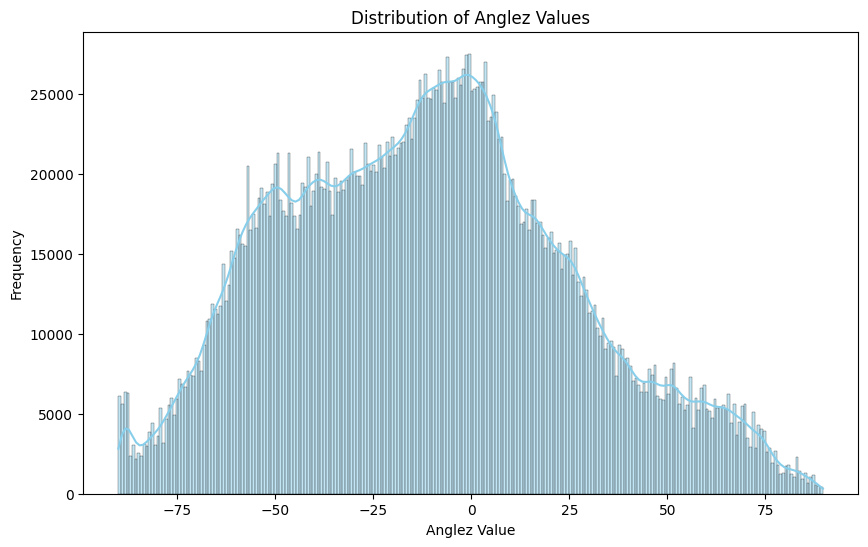

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create a distribution plot for the 'anglez' column
sns.histplot(data['anglez'], kde=True, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Anglez Value')
plt.ylabel('Frequency')
plt.title('Distribution of Anglez Values')

# Show the plot
plt.show()


Summary:
it is seen that anglez distribution is similar  to  Bell curve, meaning it is  Normal distribution

values lays in range between -90,90

## lets plot few series to see how enmo and anglez changes during time and color correspoding awake state

'08db4255286f'

<Figure size 1400x600 with 0 Axes>

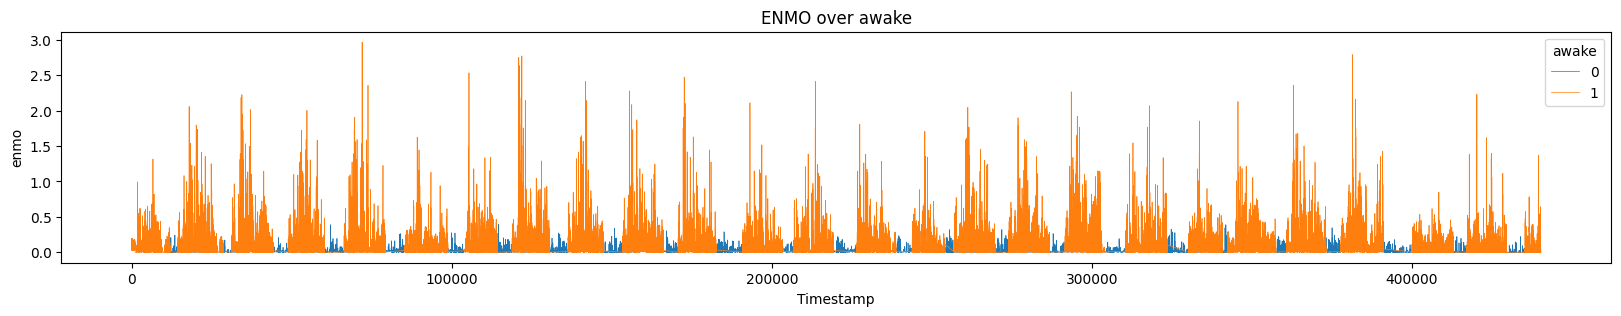

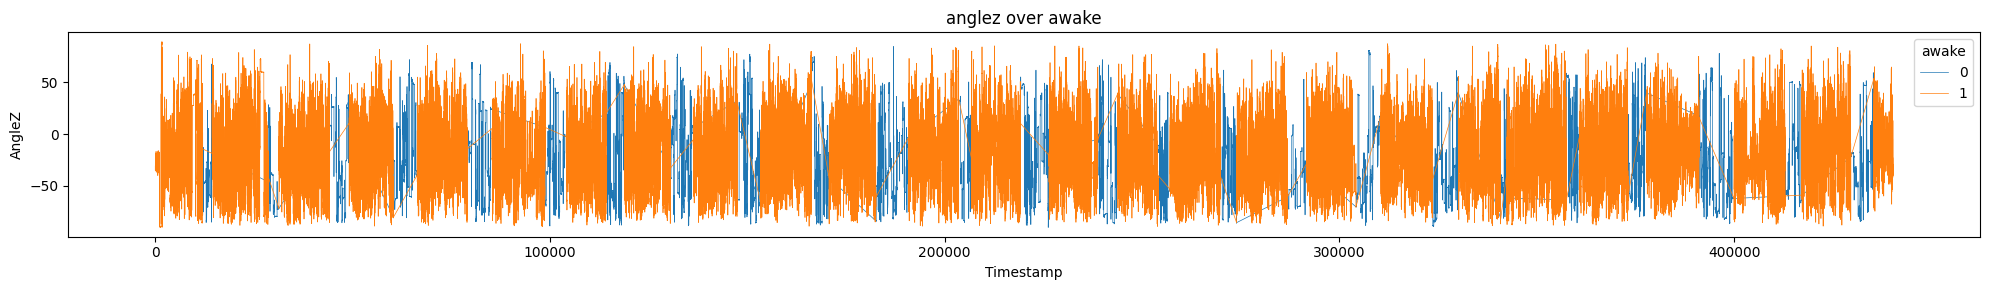

--------------------------------------------------------------------------------


'0a96f4993bd7'

<Figure size 1400x600 with 0 Axes>

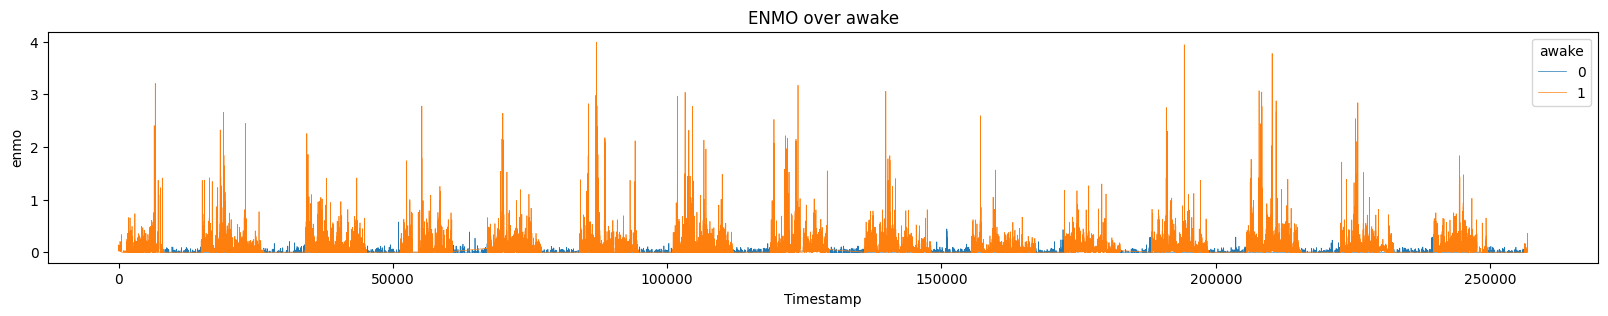

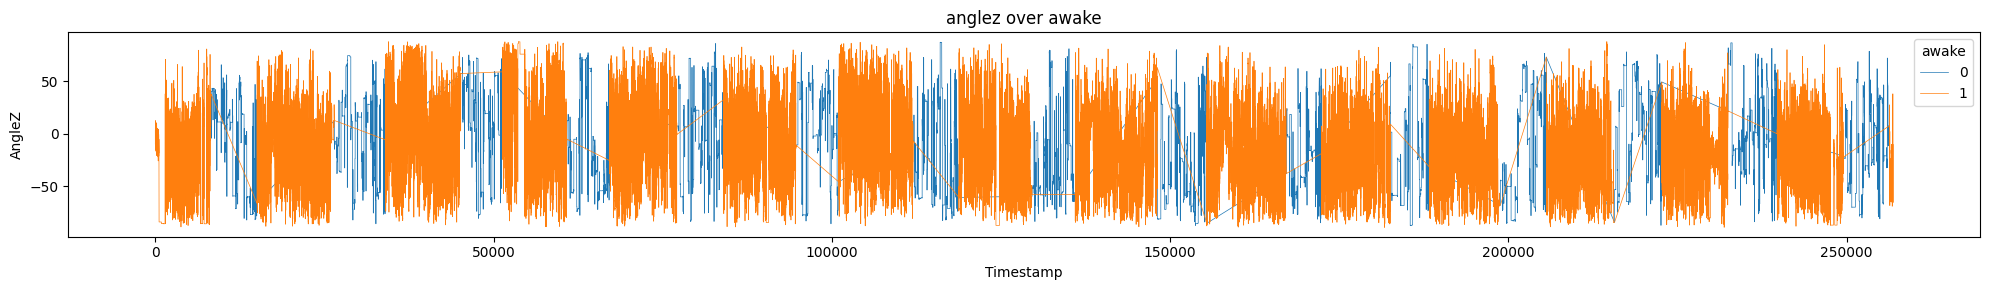

--------------------------------------------------------------------------------


'0cfc06c129cc'

<Figure size 1400x600 with 0 Axes>

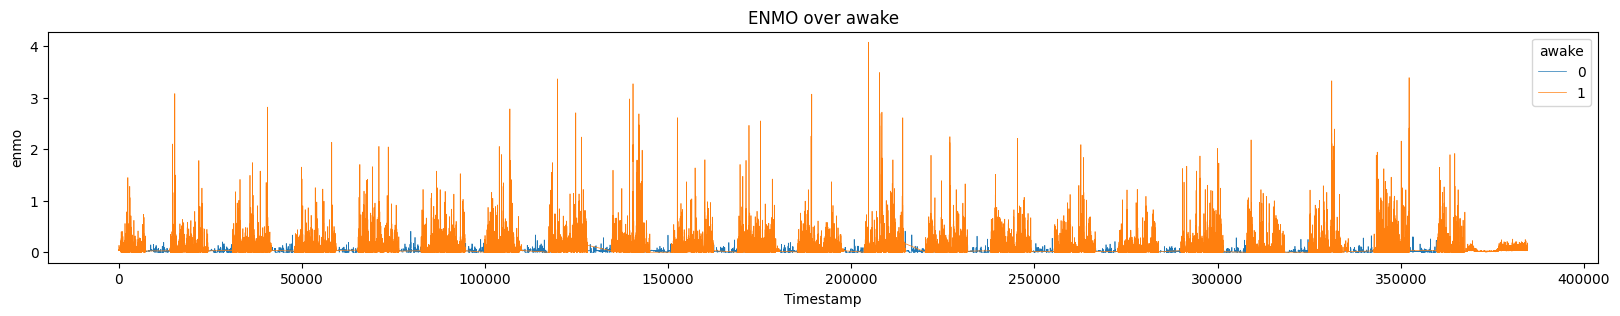

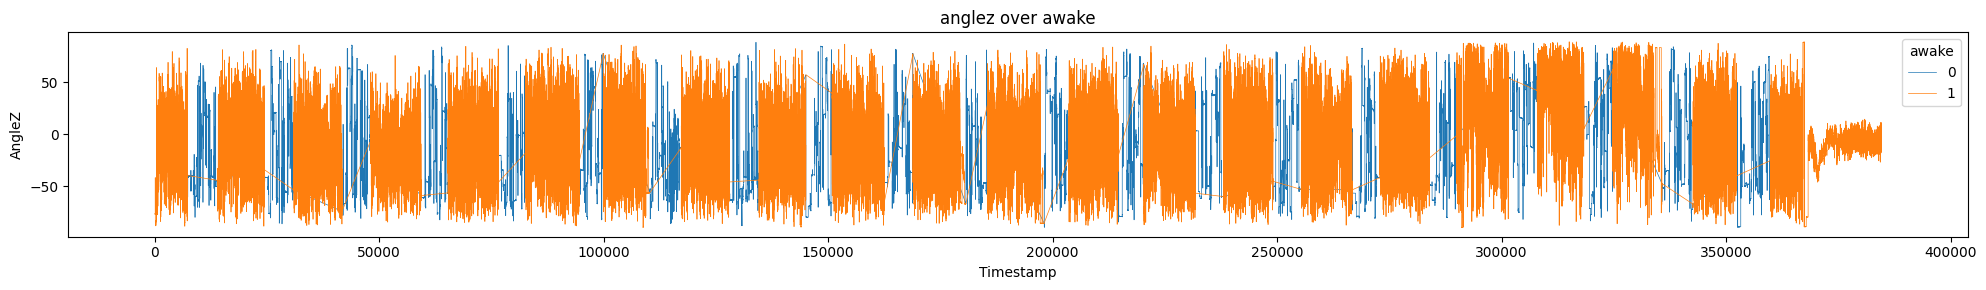

--------------------------------------------------------------------------------


In [20]:
# Filter data for a few subjects

subject_ids = data['series_id'].unique()[:3]  # Change this to select different subjects

for subject in subject_ids:
    subject_data = data[data['series_id'] == subject]
    
    display(subject)

    plt.figure(figsize=(14, 6))

    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=subject_data, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.title('ENMO over awake')
    plt.xlabel('Timestamp')
    plt.ylabel('enmo')

    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=subject_data, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.title('anglez over awake')
    plt.xlabel('Timestamp')
    plt.ylabel('AngleZ')
    plt.tight_layout()
    plt.show()
    print("-"*80)

## From the plots above it's obvious that: 

- Smaller enmo  values correlate with sleep state(0)
- Anglez values changes with following pattern: periods with more frequent changes respond to awake state(1)
whereas periods with less frequent correspond to  sleep state(0)
- "Less frequeint" periods of anglez correspond to lower enmo-values

In [21]:
values = subject_data['awake'].values
boundaries = np.where(values[:-1] != values[1:])[0] + 1 # here we get the edges of sleep and awake state

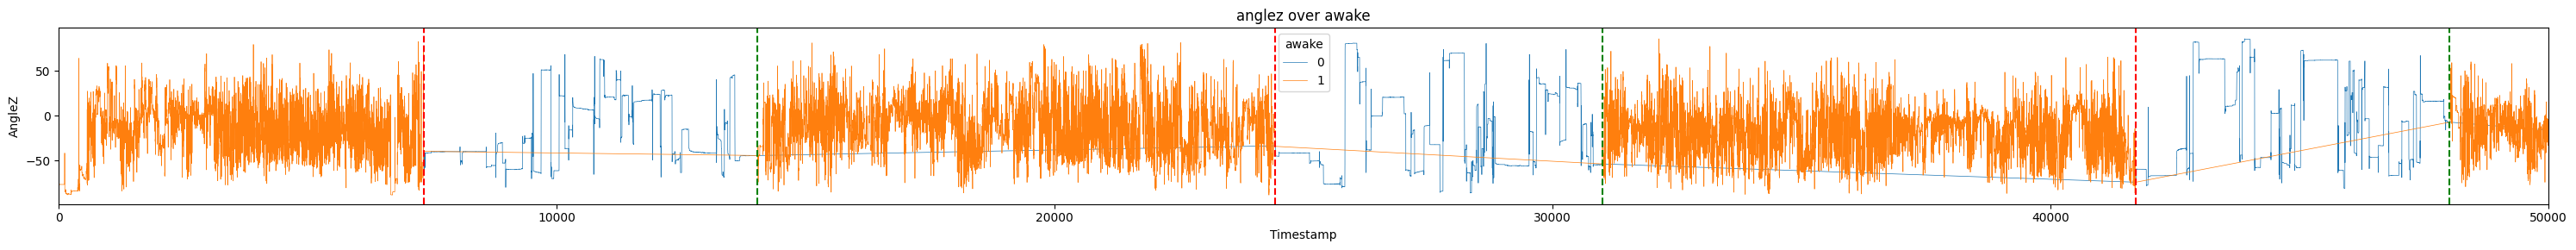

In [22]:
# this plot helps to ensure that usually during sleep state period anglez value is more stable compared to awake state.
fig, ax = plt.subplots(figsize=(30, 3))
sns.lineplot(data=subject_data, x="step", y="anglez",hue="awake", linewidth = 0.5)

for onset in boundaries:
   awake_status=subject_data.iloc[onset]['awake']
   color='g' if awake_status else 'r'

   plt.axvline(x=onset, color=color, linestyle='--', label='onset')
   
plt.title('anglez over awake')
plt.xlabel('Timestamp')
plt.ylabel('AngleZ')
plt.xlim(0,50000)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'enmo')

<Figure size 1400x600 with 0 Axes>

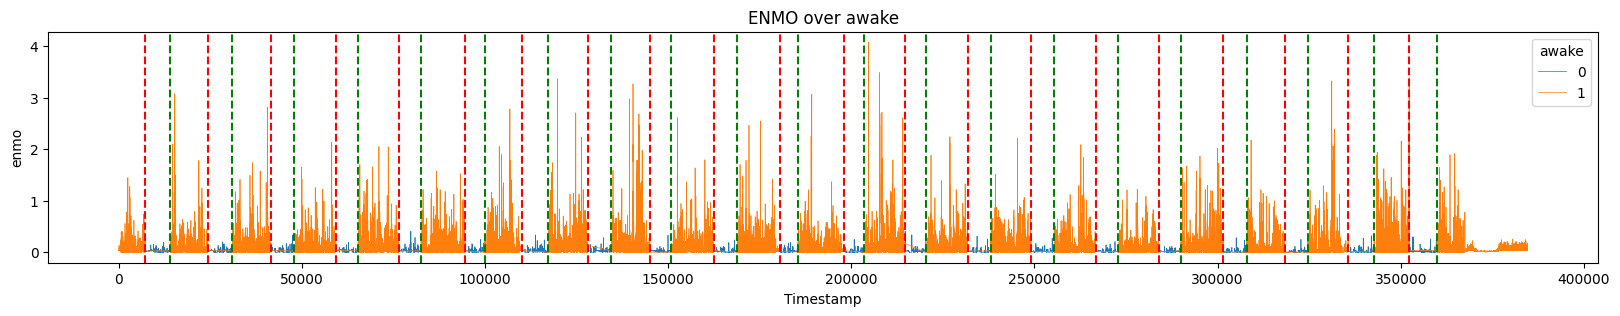

In [23]:
plt.figure(figsize=(14, 6))
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=subject_data, x="step", y="enmo",hue="awake", linewidth = 0.5)

for onset in boundaries:
   awake_status=subject_data.iloc[onset]['awake']
   color='g' if awake_status else 'r'

   plt.axvline(x=onset, color=color, linestyle='--', label='onset')

plt.title('ENMO over awake')
plt.xlabel('Timestamp')
plt.ylabel('enmo')

# 5. Feature engineering 

In [12]:
data["hour"] = data["hour"] = data["timestamp"].dt.hour
del data['timestamp']
# from nature of this feature, the sign of the anglez doesn't matter.
data["anglez"] = abs(data["anglez"])

# filter outliers
q_99=data['enmo'].quantile(0.99)
mask=data['enmo']>q_99
data['enmo'] = np.where(mask, q_99, data['enmo'])
data[['enmo']].describe(percentiles=[.25, .5, .75, 0.95, 0.99]).round(4)




,enmo
count,2380680.000
mean,0.039
std,0.066
min,0.000
25%,0.001
50%,0.015
75%,0.044
95%,0.172
99%,0.391
max,0.391


# 5.1 feature correlation

In [13]:

features = ["hour",
            "anglez",
            "enmo",
           ]

In [14]:
display(data[features].corrwith(data.awake).abs().sort_values(ascending=False))


hour     0.510
enmo     0.341
anglez   0.247
dtype: float64

# 4. Splitting the data

In [15]:
# we dont shufle for keeping order for state in datasets
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42, shuffle=False)
print(data.shape,df_full_train.shape, df_test.shape, df_train.shape, df_val.shape)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.awake.values
y_val = df_val.awake.values
y_test = df_test.awake.values

del df_train['awake']
del df_val['awake']
# del df_test['awake']
# free memory
del data
gc.collect()

(2380680, 6) (1904544, 6) (476136, 6) (1428408, 6) (476136, 6)


27

# 6 Training. Model selection

In [16]:
metrics={}
X_train = df_train[features]
X_val = df_val[features]

# free memory
del df_train
del df_val



/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Time taken: 100.36 seconds
RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42):
auc: 0.9078981385297561
acc: 0.7919228959793
logl: 1.6002181735885745


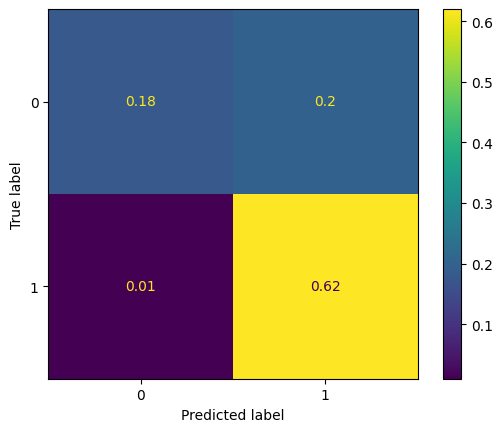

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1)
start_time = time.time()  # Record the start time
rf_classifier.fit(X_train, y_train)
y_pred_proba = rf_classifier.predict_proba(X_val)[:,1]
y_pred = rf_classifier.predict(X_val)

auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, y_pred)
logl = log_loss(y_val, y_pred_proba)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"{rf_classifier.__str__()}:\nauc: {auc}\nacc: {acc}\nlogl: {logl}")

cm=confusion_matrix(y_val, y_pred)
relative_cm=(cm / cm.sum()).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=relative_cm, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

metrics[str(rf_classifier)]={'auc':auc,
                          'accuracy': acc,
                          'log_loss': logl}


/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/anatolii/.local/share/virtualenvs/sleep-detection-5EX2S5gc/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Time taken: 9.25 seconds
LogisticRegression():
auc: 0.8771579101733895
acc: 0.8550918225044946
logl: 0.4205409386921591


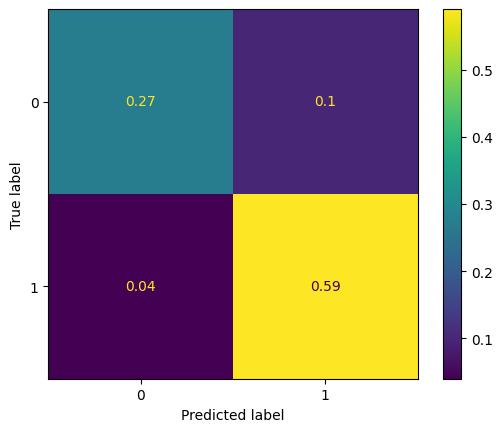

In [17]:
lr_classifier =  LogisticRegression()
start_time = time.time()  # Record the start time
lr_classifier.fit(X_train, y_train)
y_pred_proba = lr_classifier.predict_proba(X_val)[:,1]
y_pred = lr_classifier.predict(X_val)

auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, y_pred)
logl = log_loss(y_val, y_pred_proba)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"{lr_classifier.__str__()}:\nauc: {auc}\nacc: {acc}\nlogl: {logl}")

cm=confusion_matrix(y_val, y_pred)
relative_cm=(cm / cm.sum()).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=relative_cm, display_labels=lr_classifier.classes_)
disp.plot()
plt.show()

metrics[str(lr_classifier)]={'auc':auc,
                          'accuracy': acc,
                          'log_loss': logl}


Time taken: 12.93 seconds
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
auc: 0.9611025367620759
acc: 0.8809835845220694
logl: 0.2939582567575934


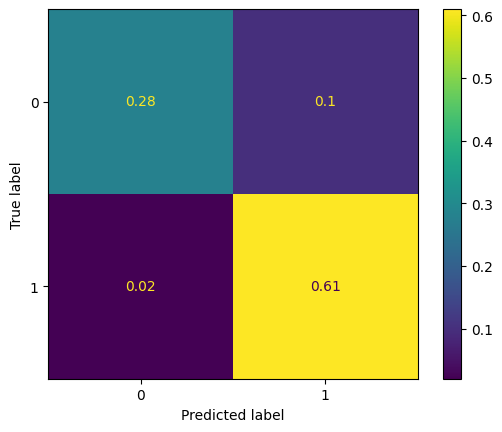

In [19]:

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

start_time = time.time()  # Record the start time
xgb_classifier = XGBClassifier(n_estimators=200, learning_rate=0.1, objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)

y_pred_proba     = xgb_classifier.predict_proba(X_val)[:,1]
y_pred     = xgb_classifier.predict(X_val)

auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, y_pred)
logl = log_loss(y_val, y_pred_proba)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"{xgb_classifier.__str__()}:\nauc: {auc}\nacc: {acc}\nlogl: {logl}")

cm=confusion_matrix(y_val, y_pred)
relative_cm=(cm / cm.sum()).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=relative_cm, display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

metrics[str(xgb_classifier)]={'auc':auc,
                          'accuracy': acc,
                          'log_loss': logl}


In [20]:
metrics

{'RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)': {'auc': 0.9078981385297561,
  'accuracy': 0.7919228959793,
  'log_loss': 1.6002181735885745},
 'LogisticRegression()': {'auc': 0.8771579101733895,
  'accuracy': 0.8550918225044946,
  'log_loss': 0.4205409386921591},
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.1, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=200, n_jobs=None,\n     

In [ ]:
# old on 3 series
# {'RandomForestClassifier(n_jobs=-1, random_state=42)': {'auc': 0.8747406939716914,
#   'accuracy': 0.7646653725272694,
#   'log_loss': 2.6556071830349244},
#  'LogisticRegression()': {'auc': 0.8692465153375171,
#   'accuracy': 0.8014928822333148,
#   'log_loss': 0.5681924353964172},
#  'RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)': {'auc': 0.8894656930001146,
#   'accuracy': 0.7643557034572009,
#   'log_loss': 2.181254447654189},
#  'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.1, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=200, n_jobs=None,\n              num_parallel_tree=None, random_state=None, ...)': {'auc': 0.8692465153375171,
#   'accuracy': 0.8014928822333148,
#   'log_loss': 0.5681924353964172}}

# 7. Hyperparameter optimisaiton
we see that Xgboost  has the best metrics

lets tune some hyper params for it


In [18]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}
# Create the XGBoost model object
xgb_classifier = XGBClassifier()
# Create the RandomizedSearchCV object

random_search = RandomizedSearchCV(xgb_classifier, 
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   random_state=42  )

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.07118528947223794, 'max_depth': 4, 'n_estimators': 64, 'subsample': 0.728034992108518}
Best score:  0.8686754764745087


# 8. Final model on full data

We built 3 classifier models:
- random forest classifier model.  with the  best roc-auc  score on validation dataset:
- linear regression classifier model *model_lin.  with best roc-auc  score on validation dataset:
- XGBoost Classifiermodel dt.  with best roc-auc  score on validation dataset: 


Then we selected random forest classifier as final model model with best parameters. Now we'll train this model on train+validation dataset and save the model

In [31]:
random_search.best_params_

{'learning_rate': 0.07118528947223794,
 'max_depth': 4,
 'n_estimators': 64,
 'subsample': 0.728034992108518}

Time taken: 6.39 seconds
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07118528947223794,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=64, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
auc: 0.9759746566400035
acc: 0.9242107297074785
logl: 0.19781218113357646


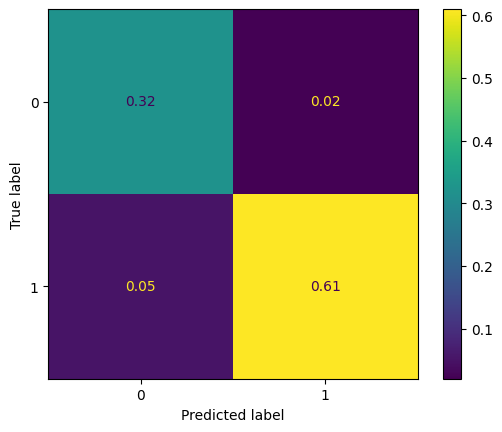

In [28]:
X_full_train= df_full_train[features]
y_full_train=df_full_train['awake']
X_test = df_test[features]

start_time = time.time()  # Record the start time
final_classifier = XGBClassifier(**random_search.best_params_)
final_classifier.fit(X_full_train, y_full_train)
y_pred_proba     = final_classifier.predict_proba(X_test)[:,1]
y_pred     = final_classifier.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
logl = log_loss(y_test, y_pred_proba)
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"{final_classifier.__str__()}:\nauc: {auc}\nacc: {acc}\nlogl: {logl}")

cm=confusion_matrix(y_test, y_pred)
relative_cm=(cm / cm.sum()).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=relative_cm, display_labels=final_classifier.classes_)
disp.plot()
plt.show()




In [33]:
final_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07118528947223794,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=64, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

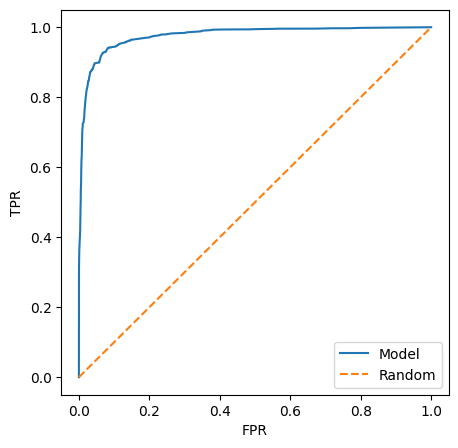

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


# 8.1 Feature importance


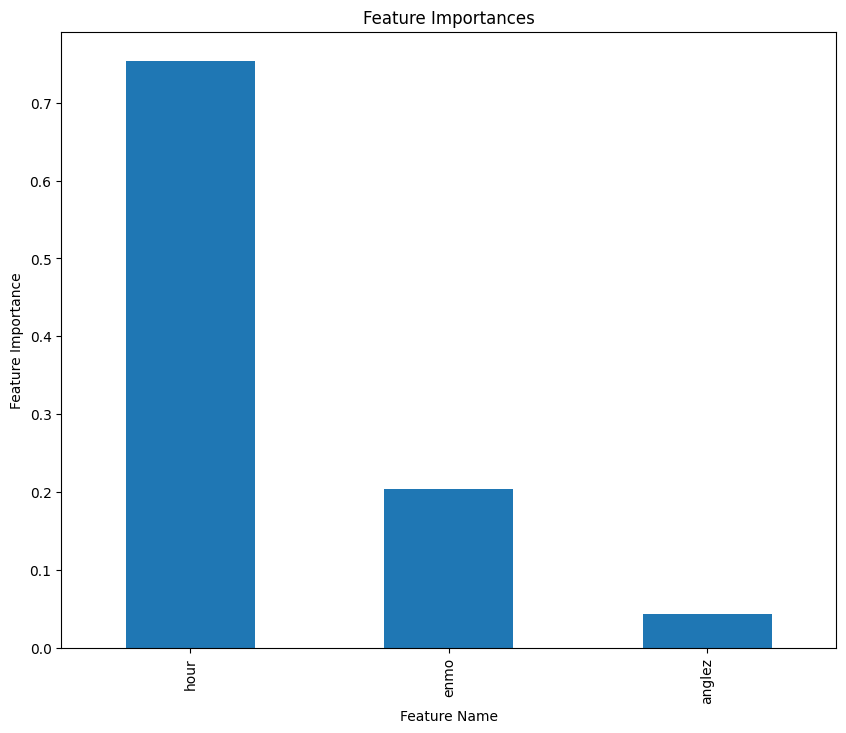

In [30]:
feature_imp = pd.Series(final_classifier.feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(10, 8))
feature_imp.sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Feature Importance')
plt.xlabel('Feature Name')
plt.title('Feature Importances')
plt.show()

In [36]:
df_full_train.iloc[[0]].to_dict()

{'series_id': {0: '08db4255286f'},
 'step': {0: 0},
 'anglez': {0: 30.845300674438477},
 'enmo': {0: 0.04470000043511391},
 'awake': {0: 1},
 'hour': {0: 10}}